In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
df = pd.read_excel('Kopie-von-radarexport_june.xlsx')
df.head()
df = df[['Normenbezeichnung','Rubrik']]
df = df[pd.notnull(df['Normenbezeichnung'])]
df.rename(columns = {'Normenbezeichnung':'article','Rubrik':'tag'}, inplace = True)
df.head(10)

,article,tag
0,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
1,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
2,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
3,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
4,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
5,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
6,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
7,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
8,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht
9,Vorschlag für eine Verordnung des Europäischen...,01. Bank- und Bankaufsichtsrecht


In [13]:

df.shape

(18448, 2)

In [14]:
df.index = range(18448)

In [15]:
df['article'].apply(lambda x: len(x.split(' '))).sum()

528619

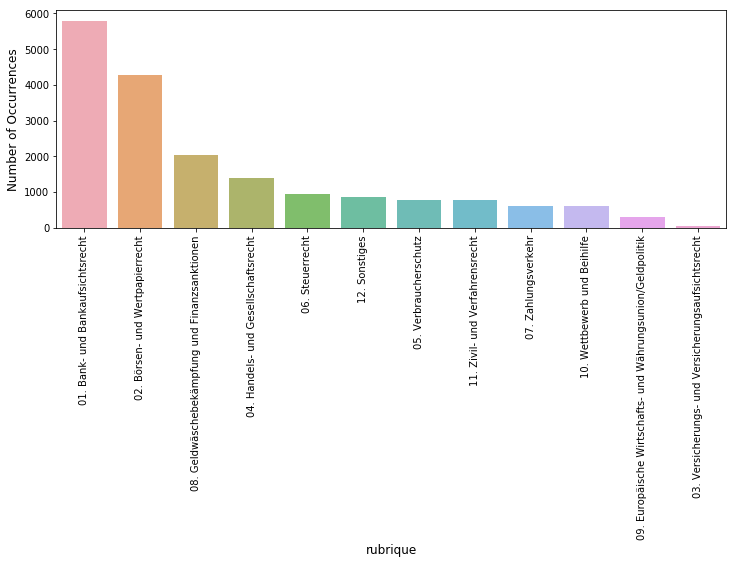

In [17]:
cnt_pro = df['tag'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('rubrique', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [19]:

def print_complaint(index):
    example = df[df.index == index][['article', 'tag']].values[0]
    if len(example) > 0:
        print(example[0])
        print('tag:', example[1])

In [21]:
print_complaint(0)


Vorschlag für eine Verordnung des Europäischen Parlaments und des Rates zur Änderung der Verordnung EU (Nr.) 575/2013 in Bezug auf die Verschuldungsquote, die strukturelle Liquiditätsquote, Anforderungen an Eigenmittel und berücksichtigungsfähige Verbindlichkeiten, das Gegenparteiausfallrisiko, das Marktrisiko, Risikopositionen gegenüber zentralen Gegenparteien, Risikopositionen gegenüber Organismen für gemeinsame Anlagen, Großkredite, Melde- und Offenlegungspflichten und zur Änderung der Verordnung (EU) Nr. 648/2012 (COM(2016) 850 final) (Datensatz 2 von 2, Teil 4 bis Teil 10 CRR (Artikel 387 - 520), Änderungen der EMIR und der Anhänge)
tag: 01. Bank- und Bankaufsichtsrecht


In [23]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['article'] = df['article'].apply(cleanText)

In [25]:
df['article'][20]

'vorschlag für eine verordnung des europäischen parlaments und des rates zur änderung der verordnung eu (nr.) 575/2013 in bezug auf die verschuldungsquote, die strukturelle liquiditätsquote, anforderungen an eigenmittel und berücksichtigungsfähige verbindlichkeiten, das gegenparteiausfallrisiko, das marktrisiko, risikopositionen gegenüber zentralen gegenparteien, risikopositionen gegenüber organismen für gemeinsame anlagen, großkredite, die melde- und offenlegungspflichten und zur änderung der verordnung (eu) nr. 648/2012  (com(2016) 850 final) (datensatz 1 von 2, teil 1 bis teil 3 crr (art. 1 - 386 crr))'

In [65]:
train, test = train_test_split(df, test_size=0.2, train_size=0.8, random_state=42)

In [66]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [67]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['article']), tags=[r.tag]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['article']), tags=[r.tag]), axis=1)

In [68]:
train_tagged.values[30]

TaggedDocument(words=['oenb', 'gemeinsames', 'meldewesen', 'datenmodell', 'version', '4.4', 'stand', '18.01.2019'], tags=['01. Bank- und Bankaufsichtsrecht'])

In [69]:
#Doc2Vec DBOW EXAMPLE 

import multiprocessing
cores = multiprocessing.cpu_count()

#building vocabulary 
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████| 14758/14758 [00:00<00:00, 924784.69it/s]


In [70]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 14758/14758 [00:00<00:00, 2467001.65it/s]


Wall time: 21 s


Buliding the final vector feature for the classifier.

In [71]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [72]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [74]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [75]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9598915989159892
Testing F1 score: 0.9598182781458813


# Distributed Memory with Averaging
Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document. We again instantiate a Doc2Vec model with a vector size with 300 words and iterating over the training corpus 30 times.

In [36]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 12913/12913 [00:00<00:00, 1078991.31it/s]


In [37]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████████████████████████████████| 12913/12913 [00:00<00:00, 3236973.92it/s]


Wall time: 35.2 s


# Train Logistic Regression


In [38]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.46124661246612464
Testing F1 score: 0.4439872996919701


# First, we delete temporary training data to free up RAM.

In [44]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# Concat two models 

In [51]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [52]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [53]:

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [54]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.9214092140921409
Testing F1 score: 0.9214535165183574
